In [99]:
import tensorflow as tf
import datetime
import os
import operator

from tensorflow.keras import backend as K
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

print(tf.__version__)
print(os.getcwd())

def createFolder(directory):
      if not os.path.exists(directory):
          os.makedirs(directory)

data_path = os.getcwd() + '/../data'
alphabet_path = data_path + '/alphebet'
createFolder(alphabet_path)

alphabet_list = os.listdir(data_path + '/ex')
alphabet_list.sort()

img_size = 36

print(data_path)
print(alphabet_list)

2.12.0
/Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code
/Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data
['a.png', 'b.png', 'c.png', 'd.png', 'e.png', 'f.png', 'g.png', 'h.png', 'i.png', 'j.png', 'k.png', 'l.png', 'm.png', 'n.png', 'o.png', 'p.png', 'q.png', 'r.png', 's.png', 't.png', 'u.png', 'v.png', 'w.png', 'x.png', 'y.png', 'z.png', 'zz.png']


In [100]:
import shutil

datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=0.01,
        fill_mode='constant',
        cval=255)

In [101]:
for j in alphabet_list:
    alpha = j.split('.')[0]
    createFolder(alphabet_path + '/' + alpha)
    
    img = load_img(data_path + '/ex/' + j)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    
    if j == 'zz.png':
      for _ in range(10):
        print(_,j, alphabet_path + '/' + alpha)
        shutil.copy(data_path + '/ex/' + j, 
                    alphabet_path + '/' + alpha + '/' + alpha + str(_)+'.jpg')
    else:  
      i = 0
      for batch in datagen.flow(x, batch_size=1,
                                save_to_dir=alphabet_path + '/' + alpha, 
                                save_prefix=alpha, 
                                save_format='jpg'):
          i += 1
          if i > 20:
              break

0 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
1 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
2 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
3 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
4 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
5 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
6 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
7 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
8 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
9 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz


In [83]:
def data_ready(size):
    datagen = ImageDataGenerator(rotation_range=10,
                                 shear_range=5,
                                 validation_split=0.3)

    train_generator = datagen.flow_from_directory(alphabet_path,
                                                  target_size=(size,size),
                                                  subset='training')

    val_generator = datagen.flow_from_directory(alphabet_path,
                                                target_size=(size,size),
                                                subset='validation')

    return train_generator, val_generator

In [84]:
def Make_model(train,val, class_count, size = 36):
    K.clear_session()

    model_ckpt = ModelCheckpoint('ckpt.h5',save_best_only=True)
    reduce_lr = ReduceLROnPlateau(patience=8,verbose=1)
    early_stop = EarlyStopping(patience=20,verbose=2)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    entry = L.Input(shape=(size,size,3))
    x = L.SeparableConv2D(64,(3,3),activation='relu',padding ='same')(entry)
    x = L.MaxPooling2D((2,2))(x)

    x = L.SeparableConv2D(128,(3,3),activation='relu',padding ='same')(x)
    x = L.MaxPooling2D((2,2))(x)

    x = L.SeparableConv2D(256,(2,2),activation='relu',padding ='same')(x)
    x = L.GlobalMaxPooling2D()(x)

    x = L.Dense(256)(x)
    x = L.LeakyReLU()(x)
    x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
    x = L.LeakyReLU()(x)
    x = L.Dense(class_count,activation='softmax')(x)

    model = Model(entry,x)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    history = model.fit(train,
                        validation_data=val,
                        epochs=999,
                        callbacks=[model_ckpt,reduce_lr,early_stop],
                        verbose=1)
    return history

In [85]:
train_generator, val_generator = data_ready(img_size)

Found 4170 images belonging to 27 classes.
Found 1772 images belonging to 27 classes.


In [86]:
with tf.device('/GPU:0'):
    try:
        load_model('ckpt.h5')
    except:
        hist = Make_model(train_generator, 
                          val_generator,
                          len(alphabet_list),
                          img_size)

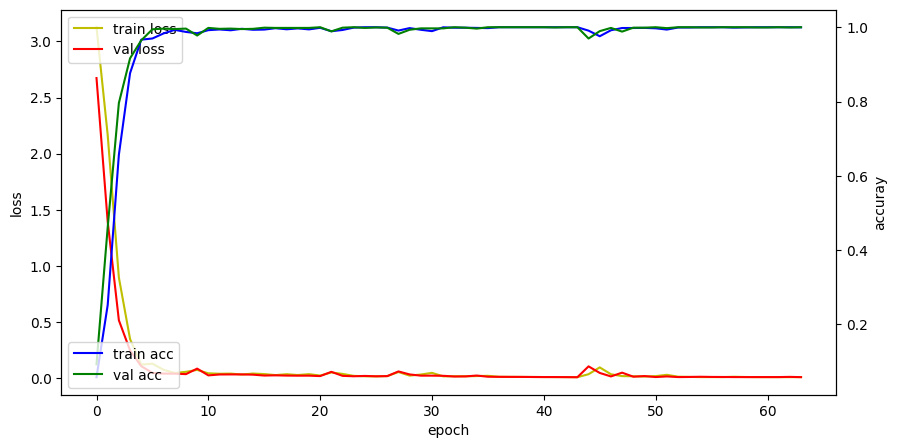

In [87]:
import matplotlib.pyplot as plt

_, loss_ax = plt.subplots(figsize=(10, 5))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [88]:
model = load_model('ckpt.h5')
acc = model.evaluate(val_generator)[1]
print('model accuracy: {}'.format(round(acc,4)))

2023-06-01 21:33:24.912021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-01 21:33:25.020953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 2s 32ms/step - loss: 0.0096 - accuracy: 1.0000
model accuracy: 1.0


In [89]:
import PIL.Image as Img
import numpy as np

def get_test_img(path):
  img = Img.open(path).convert('RGB')
  img = img.resize((img_size, img_size))
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)

  return x

In [90]:
test_image = get_test_img(data_path + '/ex/a.png')
result = model.predict(test_image)

max = np.max(result)
index = np.where(result == max)

print(max, *index[1])

1/1 [==============================] - 0s 252ms/step
0.99999654 0


2023-06-01 21:33:27.185673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [91]:
label = []

for file in alphabet_list:
  label.append(file.split('.')[0])

label.sort()
del label[label.index('zz')]
print(label)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [92]:
def decode_predict(result, lables):
  max = np.max(result)
  index = np.where(result == max)
  # print(index[1])
  # print(tags[index[1][0]])

  return lables[index[1][0]]


In [93]:
test_image = get_test_img(alphabet_path + '/k/k_0_2641.jpg')
result = model.predict(test_image)
decoded = decode_predict(result, lables=label)

print(f'predicted! : {decoded}')

1/1 [==============================] - 0s 25ms/step
predicted! : k


In [103]:
from PIL import Image
import os

class img_devide():
    def __init__(self, img_path):
        self.img_path = data_path + '/../test/'
        self.img_name = img_path
        
        self.call_num = 0
        self.lengh = 0
        self.width = 0
        self.height = 0
        self.img = ''


    def create_dir(self):
        try:
            os.mkdir(self.img_path + 'tmp/')
            print('create new dir')
        except:
            print('already exist')
            pass
        self.path = self.img_path


    def devide_img(self):
        self.img = Image.open(self.img_path + '/' + self.img_name)
        area = (0 + self.call_num * self.height, 0,
                self.width / self.lengh * (self.call_num + 1), self.height)
        
        cropped_img = self.img.crop(area)
        cropped_img.save(self.img_path + 'tmp/' + str(self.call_num) + '.jpg')

        self.call_num += 1


    def set_image(self):
        self.img = Image.open(self.img_path + '/' + self.img_name)
        self.width = self.img.size[0]
        self.height = self.img.size[1]
        self.lengh = int(self.width / self.height)

    def remove_file(self):
        try:
            os.remove(self.img_path + 'tmp/' + str(self.call_num - 1 )+ '.jpg')
        except:
            pass

    def remove_dir(self) :
        try:
            os.rmdir(self.img_path + 'tmp/')
        except:
            print('fail')


In [104]:
class Predicter():
    result = []
    def predict(self, model, real):
        my_list = model.predict(real)
        index, value = max(enumerate(my_list[0]), 
                           key=operator.itemgetter(1))
        print(index, alpha(index))
        self.result.append(alpha(index))
        return self.result

    def reset(self):
        self.result = []

def chk_trans():
    for i in range(0, 27):
        print(str(i) + ':' + alpha(i),end='  ')
        if i%3 ==2 :
            print()

In [105]:
def alpha(num):
    if num == 26:
        return  ' '
    else:
        num_tr = num+97
        return chr(num_tr)

In [112]:
def load_image(img_path):
    print(img_path + 'tmp/')
    datagen = ImageDataGenerator()
    real_generator = datagen.flow_from_directory(img_path + 'tmp/',
                                                 target_size=(img_size, img_size))

    return real_generator

In [113]:
def action(path):
    chk_trans()
    predicter = Predicter()
    devider = img_devide(path)

    devider.create_dir()
    devider.set_image()
    predicter.reset()

    for _ in range(devider.lengh):
        devider.devide_img()
        img = load_image(devider.img_path)
        predicter.predict(model, img)
        img.remove_file()


    print(predicter.result)
    result = ''.join(predicter.result)
    return result

In [114]:
model = load_model('ckpt.h5')
action('hello.jpg')

0:a  1:b  2:c  
3:d  4:e  5:f  
6:g  7:h  8:i  
9:j  10:k  11:l  
12:m  13:n  14:o  
15:p  16:q  17:r  
18:s  19:t  20:u  
21:v  22:w  23:x  
24:y  25:z  26:   
already exist
/Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/../test/tmp/
Found 0 images belonging to 0 classes.


ValueError: Asked to retrieve element 0, but the Sequence has length 0